In [1]:
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from sklearn import preprocessing


/home/hang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Number of samples 55000 Shape of y[(55000, 10)] Shape of X[(55000, 784)]


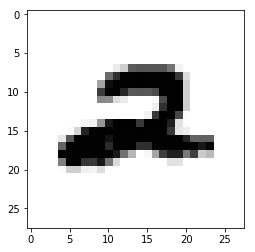

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples
print("Number of samples {} Shape of y[{}] Shape of X[{}]"
      .format(n_samples, mnist.train.labels.shape, mnist.train.images.shape))
plt.imshow(np.reshape(-mnist.train.images[4242], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))

plt.show()

In [3]:
# encoder neural network - take as input observation x, output mu and sigma of latent variable z and content h
class Encoder(object):
    def __init__(self,inputs,hidden_dim,z_dim,h_dim):
        self.X=inputs
        self.layer_dims=[inputs.get_shape()[1], hidden_dim,hidden_dim, z_dim * 2 + h_dim] # output of Encoder (z_mu, z_sigma, h)
        self.nz=z_dim
        self.nh=h_dim
        with tf.variable_scope('encoder'):
            self.parameters = self._initialize_parameters()
            
    def _initialize_parameters(self):
        L=len(self.layer_dims)
        parameters={}
        for l in range(1,L-1):            
            parameters['W' + str(l)] = tf.get_variable('W'+str(l),[self.layer_dims[l],self.layer_dims[l-1]],initializer=tf.contrib.layers.variance_scaling_initializer(factor=0.002))
            parameters['b' + str(l)] = tf.get_variable('b'+str(l),self.layer_dims[l],initializer=tf.zeros_initializer())
        
        w_s = tf.get_variable('w_s',[self.nz,self.layer_dims[L-2]],initializer=tf.contrib.layers.variance_scaling_initializer(factor=0.002))
        w_o = tf.get_variable('w_o',[self.nz+self.nh,self.layer_dims[L-2]],initializer=tf.contrib.layers.variance_scaling_initializer())
        parameters['W'+str(L-1)] = tf.concat([w_s,w_o],axis = 0,name='W'+str(L-1))
        parameters['b'+str(L-1)] = tf.get_variable('b'+str(L-1),self.layer_dims[L-1],initializer=tf.constant_initializer(-6))
        return parameters
    
    def encoding(self):
        L=len(self.layer_dims)
        A=self.X
        for l in range(1,L):
            Z = tf.add(tf.matmul(A,tf.transpose(self.parameters['W'+str(l)])),self.parameters['b'+str(l)])
            if l < (L-1):  # activation for hidden layer
                A = tf.nn.relu(Z)
            else:  # activation for output layer
                A1 = Z[:,:self.nz] #sigma when initialize, set weights values very small using factor=0.002
                A2 = Z[:,self.nz:2 * self.nz] #mu
                A3 = Z[:,2 * self.nz:] #h
        return A1, A2, A3

In [4]:
# decoder neural network - take as input latent variable z, output reconstructed x_hat
class Decoder(object):
    def __init__(self,inputs,hidden_dim):
        self.X=inputs
        self.nz = inputs.get_shape()[1]
        self.layer_dims = [self.nz, hidden_dim,hidden_dim, 784]
        with tf.variable_scope('decoder'):
            self.parameters = self._initialize_parameters()
            
    def _initialize_parameters(self):
        L=len(self.layer_dims)
        parameters={}
        for l in range(1,L):            
            parameters['W' + str(l)] = tf.get_variable('W'+str(l),[self.layer_dims[l],self.layer_dims[l-1]],initializer=tf.contrib.layers.variance_scaling_initializer())
            parameters['b' + str(l)] = tf.get_variable('b'+str(l),self.layer_dims[l],initializer=tf.zeros_initializer())
        return parameters
    
    def decoding(self):
        L=len(self.layer_dims)    
        A=self.X
        for l in range(1,L):
            Z = tf.add(tf.matmul(A,tf.transpose(self.parameters['W'+str(l)])),self.parameters['b'+str(l)])
            if l<L-1:
                A = tf.nn.relu(Z)
            else:
                A = tf.nn.sigmoid(Z)   

    
        return A 

In [5]:
# autoregressive neural network - take as input z_(t-1) and h, output mean and sigma of z_(t)
class AutoregNN(object):
    def __init__(self,input_z,input_h,layer_dims,idx,verbose = False):
        self.Z = input_z
        self.h = input_h
        self.z_dim = input_z.get_shape().as_list()[1]
        self.h_dim = input_h.get_shape().as_list()[1]
        self.D= self.z_dim
        self.layer_dims=layer_dims # z_dim + h_dim, arbitrary, arbitrary, z_dim + z_dim
        assert self.layer_dims[0] == self.z_dim + self.h_dim
        assert self.layer_dims[-1] == self.z_dim * 2
        self.verbose = verbose
        
        with tf.variable_scope('autoregressive_nn'+str(idx)):
            self.parameters=self._initialize_parameters()
        with tf.name_scope('autoregressive_nn'+str(idx)):
            self.mask=self.build_mask() 
        
    #initialize parameters
    def _initialize_parameters(self):
        L = len(self.layer_dims)
        parameters={}
        for l in range(1,L-1):
            
            parameters['W' + str(l)] = tf.get_variable('W'+str(l),[self.layer_dims[l],self.layer_dims[l-1]],initializer=tf.contrib.layers.variance_scaling_initializer(factor=0.2))
            parameters['b' + str(l)] = tf.get_variable('b'+str(l),self.layer_dims[l],initializer=tf.zeros_initializer()) 
        
        for l in [L-1]:
            parameters['W' + str(l)] = tf.get_variable('W'+str(l),[self.layer_dims[l],self.layer_dims[l-1]],initializer=tf.contrib.layers.variance_scaling_initializer())
            parameters['b' + str(l)] = tf.get_variable('b'+str(l),self.layer_dims[l],initializer=tf.constant_initializer(2.)) 

        
        #for direct connection
        parameters['WA']=tf.get_variable('WA',[self.layer_dims[L-1],self.z_dim],initializer=tf.contrib.layers.xavier_initializer())
        parameters['bA']=tf.get_variable('bA',self.layer_dims[L-1],initializer=tf.constant_initializer(1.))
        
        return parameters 

    # build mask    
    def single_mask(self, m_h, l, Isoutput=False):
        if l==0:
            raise ValueError('No mask for W0')        
        if Isoutput==False:
            M=np.array([[m_h[l][k]>=m_h[l-1][d] for d in range(self.layer_dims[l-1])] for k in range(self.layer_dims[l])],dtype=int)
        if Isoutput==True:
            M=np.array([[m_h[l][k]>m_h[l-1][d] for d in range(self.layer_dims[l-1])] for k in range(self.layer_dims[l])],dtype=int)
        if self.verbose:
            print('M%d:'%l + '{}'.format(M))
        return M    
    
    def build_mask(self):
        L=len(self.layer_dims)
        mask={}        
        #create mask number of each unit
        input_sel_z = np.arange(0,self.z_dim)
        input_sel_h = np.zeros(self.h_dim)-1 # a little trick to let input h be fully connected to first hidden layer 
                                    # it shouldn't have mask, but we set the mask to be True = set input_sel_h smaller than any mask number
        input_sel = np.concatenate((input_sel_z,input_sel_h))
        output_sel = np.concatenate((input_sel_z, input_sel_z))
        m_h=[input_sel]
        #np.random.seed(0)
        for l in range(1,L-1):
            m_h.append(np.random.randint(self.D-1,size=self.layer_dims[l]))
        m_h.append(output_sel)
        if self.verbose:
            print('m_h: {}'.format(m_h))
        
        for l in range(1,L-1):
            M=self.single_mask(m_h,l,Isoutput=False)
            mask['M'+str(l)]=tf.constant(M,dtype=tf.float32,name='M'+str(l))
        for l in range(L-1,L):           
            M=self.single_mask(m_h,l,Isoutput=True)
            mask['M'+str(l)]=tf.constant(M,dtype=tf.float32,name='M'+str(l))
    
        # for direct connection
        input_sel_direct = input_sel_z
        output_sel_direct = np.concatenate((input_sel_z, input_sel_z))
        M=np.array([[i<j for i in input_sel_direct] for j in output_sel_direct],dtype=int)
        if self.verbose:
            print('MA: {}'.format(M))
        mask['MA']=tf.constant(M,dtype=tf.float32,name='MA')                      
        
        return mask
    
    # forward compute
    def iaf(self):
        L=len(self.layer_dims)    
        A_in=tf.concat((self.Z,self.h),axis = 1)
        A = A_in
        for l in range(1,L):
            masked_W=np.dot(self.parameters['W'+str(l)], self.mask['M'+str(l)])
            b=self.parameters['b'+str(l)]
            Z=tf.add(tf.matmul(A,tf.transpose(masked_W)),b)
            if l < (L-1):  # activation for hidden layer
                A=tf.nn.relu(Z)
            else:  # activation for output layer
                A=Z 
                
        #for direct conection
        masked_W= np.dot(self.parameters['WA'], self.mask['MA'])
        A_direct=tf.add(tf.matmul(self.Z,tf.transpose(masked_W)),self.parameters['bA'])
        
        A = tf.add(A,A_direct)
        A1 = A[:,self.z_dim:] #s
        A2 = A[:,:self.z_dim] #m

        
        return A1,A2,self.parameters

In [6]:
# built model
tf.reset_default_graph()
with tf.name_scope('inputs'):
    X = tf.placeholder("float", shape=[None, 784]) 

with tf.name_scope('encoding_stage'):
    encoder=Encoder(inputs=X,hidden_dim=500,z_dim=2,h_dim=10)
    z_log_sigma_0,z_mu_0,h=encoder.encoding()
    epsilon = tf.random_normal(tf.shape(z_mu_0),0,1,dtype=tf.float32)
    Z = np.dot(tf.exp(z_log_sigma_0/2) , epsilon) + z_mu_0

with tf.name_scope('iaf_stage'):
    z_sigmas=[]
    reg_loss = 0.
    for t in range(4):
        reverse = t>0
        if reverse:
            Z = Z[:,::-1]
        IAF = AutoregNN(input_z=Z,input_h=h,layer_dims=[12,100,100,4],idx=t)
        m,s,iparam = IAF.iaf()
        z_sigma = tf.sigmoid(s)
        Z = np.dot(z_sigma , Z) + np.dot(1 - z_sigma ,  m)
        z_sigmas.append(z_sigma)
        reg_loss += tf.nn.l2_loss(iparam["W1"])+tf.nn.l2_loss(iparam["W2"])+tf.nn.l2_loss(iparam["W3"])+tf.nn.l2_loss(iparam["WA"])
with tf.name_scope('decoding_stage'):
    decoder=Decoder(inputs=Z,hidden_dim=500)
    x_mu_hat = decoder.decoding()


In [7]:
# vae - iaf negative evidence lower bound - based on monte carlo sampling
def neg_elbo(X,x_mu_hat,Z):
    # log p(x|z_t)
    log_px = -tf.reduce_sum(X * tf.log(1e-10 + x_mu_hat) + (1-X) * tf.log(1e-10 + 1 - x_mu_hat), axis=-1)   
    
    # log p(z_t)
    log_pz = -tf.reduce_sum(0.5*Z**2, axis=-1)
  
    # log q(z_t|x)
    det=np.zeros_like(z_sigmas[0])
    for item in z_sigmas:
        det+=tf.log(item)    
    log_qz = -tf.reduce_sum(0.5*epsilon**2 + 0.5*z_log_sigma_0+det,axis=-1) 
    
    return tf.reduce_mean(log_px+log_qz-log_pz) + 0.01*reg_loss

In [8]:
# training
def training(num_epochs = 1000, batch_size = 32, log_every=10,learning_rate = 0.001, verbose = False):

    with tf.name_scope('training_loss'):
        loss = neg_elbo(X,x_mu_hat,Z)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    # training
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(num_epochs):
            avg_cost = 0.
            num_batch = int(n_samples / batch_size)
            
            for i in range(num_batch):
                mini_batch, mini_label = mnist.train.next_batch(batch_size)
                _,temp_cost,z_values = sess.run([optimizer, loss,z_log_sigma_0], feed_dict={X: mini_batch})
                avg_cost += temp_cost / n_samples * batch_size
            
            if verbose and epoch % log_every ==0:
                save_path = saver.save(sess, "iafmnist/iafmnist.ckpt")
                print('%d-th train ' % (epoch) + 'cost:{} {}'.format(avg_cost,np.mean(z_values)))
    return None

In [91]:
training(num_epochs=500, batch_size = 200, log_every = 1, verbose=True)

0-th train cost:218.00868685635675 -3.148116111755371
1-th train cost:177.21460438121457 -3.7423784732818604
2-th train cost:170.39865417480456 -4.151371955871582
3-th train cost:166.68361849698152 -4.4144110679626465
4-th train cost:164.490971291282 -4.456427574157715
5-th train cost:162.7261896306818 -4.5876641273498535
6-th train cost:161.5760364879261 -4.645597457885742
7-th train cost:160.05920731977986 -4.8163957595825195
8-th train cost:159.24323042436086 -5.0451459884643555
9-th train cost:158.35958901145227 -4.995668411254883
10-th train cost:157.77385620117175 -5.127269268035889
11-th train cost:157.1939127419212 -5.183229923248291
12-th train cost:156.6668263383345 -5.231800556182861
13-th train cost:156.00657986727632 -5.251016616821289
14-th train cost:155.6352054110441 -5.339222431182861
15-th train cost:155.12962063876066 -5.339994430541992
16-th train cost:154.79751253995028 -5.251043796539307
17-th train cost:154.63506841486156 -5.331535816192627
18-th train cost:154.2

149-th train cost:148.2402505215732 -4.5843987464904785
150-th train cost:147.6915802001953 -4.708986282348633
151-th train cost:148.010614790483 -4.470135688781738
152-th train cost:147.7234923761541 -4.610180854797363
153-th train cost:148.49032792524878 -4.685436248779297
154-th train cost:148.28733098810372 -4.493285655975342
155-th train cost:148.2677935791015 -4.549884796142578
156-th train cost:147.96915399724796 -4.558027267456055
157-th train cost:148.59637867320666 -4.663832187652588
158-th train cost:148.18778592196375 -4.629491806030273
159-th train cost:148.53308116566043 -4.473679065704346
160-th train cost:148.37379161487934 -4.489471435546875
161-th train cost:147.67511596679694 -4.420216083526611
162-th train cost:147.89278015136722 -4.463669300079346
163-th train cost:147.92621626420453 -4.512628078460693
164-th train cost:147.58342862215912 -4.593786716461182
165-th train cost:147.55684093128548 -4.506802558898926
166-th train cost:147.57333257501773 -4.4558124542236

296-th train cost:147.30108908913343 -3.5591986179351807
297-th train cost:146.8197939231179 -3.470412254333496
298-th train cost:146.8741386274857 -3.379929780960083
299-th train cost:147.67090387517763 -3.465153694152832
300-th train cost:148.37411132812497 -3.4332849979400635
301-th train cost:147.29272133567108 -3.5252137184143066
302-th train cost:147.3609674627131 -3.5417914390563965
303-th train cost:147.28299926757802 -3.422255754470825
304-th train cost:146.9980691805753 -3.4581713676452637
305-th train cost:146.7411431329901 -3.4046173095703125
306-th train cost:147.6541283069957 -3.390043258666992
307-th train cost:147.03337907270947 -3.403937578201294
308-th train cost:147.0003455699574 -3.438666343688965
309-th train cost:147.61058455033742 -3.2912676334381104
310-th train cost:147.10892017711285 -3.3697845935821533
311-th train cost:147.09236722079189 -3.2829370498657227
312-th train cost:146.77244262695308 -3.3464438915252686
313-th train cost:146.1830881014736 -3.291743

442-th train cost:145.2643988037109 -2.656325578689575
443-th train cost:145.37442577015273 -2.6215126514434814
444-th train cost:145.57739468661228 -2.677982807159424
445-th train cost:145.300122347745 -2.493199586868286
446-th train cost:144.90382690429703 -2.6004421710968018
447-th train cost:144.98497381036935 -2.680288791656494
448-th train cost:144.781675415039 -2.6644115447998047
449-th train cost:144.97189641779119 -2.5348474979400635
450-th train cost:145.06567238547595 -2.7773194313049316
451-th train cost:145.07361477938557 -2.671238899230957
452-th train cost:145.39682861328134 -2.7243573665618896
453-th train cost:145.2332433527167 -2.7101776599884033
454-th train cost:145.80351839932527 -2.522465944290161
455-th train cost:145.9169194446911 -2.639166831970215
456-th train cost:146.34249983354044 -2.617385149002075
457-th train cost:147.60428089488636 -2.698066473007202
458-th train cost:147.04690923517396 -2.778419256210327
459-th train cost:146.74687045010646 -2.63452506

In [9]:
#plot results
#copy from https://github.com/oduerr/dl_tutorial/blob/master/tensorflow/vae/vae_demo.ipynb
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "iafmnist/iafmnist.ckpt")
    x_sample = mnist.test.next_batch(64)[0]
    x_reconstruct,z_vals,z_mean_val,z_log_sigma_0_val  = sess.run((x_mu_hat,Z, z_mu_0, z_log_sigma_0), feed_dict={X: x_sample})

    plt.figure(figsize=(8, 12))
    for i in range(5):
        plt.subplot(5, 3, 3*i + 1)
        plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1,  interpolation='none',cmap=plt.get_cmap('gray'))
        plt.title("Test input")
        
        #plt.colorbar()
        plt.subplot(5, 3, 3*i + 2)
        plt.scatter(z_vals[:,0],z_vals[:,1], c='gray', alpha=0.5)
        plt.scatter(z_mean_val[i,0],z_mean_val[i,1], c='green', s=64, alpha=0.5)
        plt.scatter(z_vals[i,0],z_vals[i,1], c='blue', s=16, alpha=0.5)
               
        plt.xlim((-3,3))
        plt.ylim((-3,3))
        plt.title("Latent Space")
        
        plt.subplot(5, 3, 3*i + 3)
        plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, interpolation='none',cmap=plt.get_cmap('gray'))
        plt.title("Reconstruction")
        #plt.colorbar()
    plt.tight_layout()
    plt.show()

INFO:tensorflow:Restoring parameters from iafmnist/iafmnist.ckpt


NotFoundError: Key autoregressive_nn0/W1 not found in checkpoint
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]

Caused by op 'save/RestoreV2', defined at:
  File "/home/hang/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/hang/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/hang/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/hang/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/hang/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/hang/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/hang/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/hang/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-2ae783dc9a70>", line 3, in <module>
    saver = tf.train.Saver()
  File "/home/hang/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1311, in __init__
    self.build()
  File "/home/hang/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1320, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1357, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 809, in _build_internal
    restore_sequentially, reshape)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 448, in _AddRestoreOps
    restore_sequentially)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 860, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1458, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/hang/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key autoregressive_nn0/W1 not found in checkpoint
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]


INFO:tensorflow:Restoring parameters from iafmnist/iafmnist.ckpt


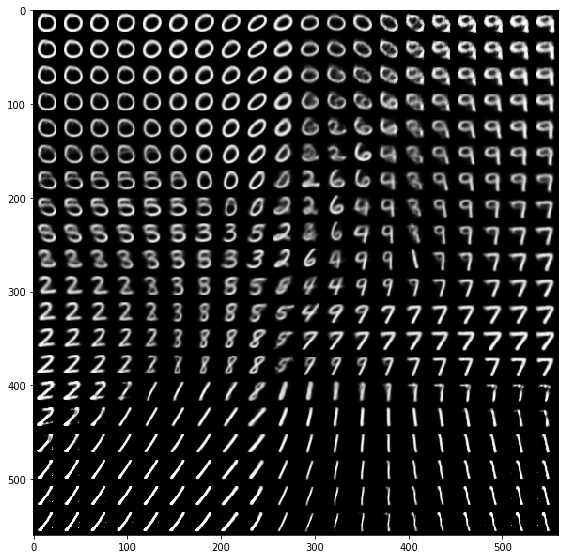

In [100]:
nx = ny = 20
batch_size = 64
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((28*ny, 28*nx))
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "iafmnist/iafmnist.ckpt")
    d = np.zeros([batch_size,2],dtype='float32')
    for i, yi in enumerate(x_values):
        for j, xi in enumerate(y_values):
            z_mu = np.array([[xi, yi]])
            d[0] = z_mu
            x_mean = sess.run(x_mu_hat, feed_dict={Z: d})
            canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()